In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

### Load all training images and labels

      Unnamed: 0         img name  tumor types
0              0           000137            1
1              1         case0419            1
2              2         case0024            0
3              3     benign (397)            0
4              4         case0287            0
...          ...              ...          ...
2379        2379  malignant (143)            1
2380        2380         case0441            1
2381        2381     benign (162)            0
2382        2382           000064            0
2383        2383           000022            0

[2384 rows x 3 columns]
loading images ...
0 000137
1 case0419
2 case0024
3 benign (397)
4 case0287
5 case0408
6 case0142
7 63404-Afbeelding1
8 63405-Afbeelding2
9 Case-9-U-18-1
10 Case-9-U-18-2
11 benign (21)
12 39094-Afbeelding1
13 39095-Afbeelding2
14 39097-Afbeelding4
15 39100-Afbeelding7
16 39096-Afbeelding3
17 000111
18 benign (307)
19 3698
20 3699
21 3700
22 benign (213)
23 case0534
24 benign (276)
25 benign (137)
26 18061
2

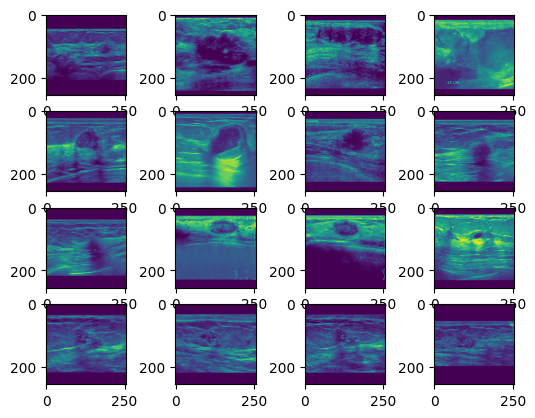

In [2]:
# load all training images and labels
train_img_folder = 'trainImgs'
train = pd.read_csv('train.csv')
print(train)

trainImg_names = list(train['img name']) 
input_size = 256
print('loading images ...')
X_train = []
for idx, name in enumerate(trainImg_names):
    img = image.load_img(os.path.join(train_img_folder, name +'.png'), color_mode = "grayscale", target_size = (input_size, input_size))
    img = image.img_to_array(img)
    X_train.append(img)
    print(idx, name)
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(train['tumor types'])

# convert class vectors to binary class matrices
y_train_onehot = tf.keras.utils.to_categorical(y_train)
print(y_train_onehot.shape)

print('loading finished ...')
print(X_train.shape, y_train_onehot)

nImg = 4  
for i in range(nImg*nImg):
    plt.subplot(nImg, nImg, i+1)
    plt.imshow(X_train[i])
plt.show()

#### Your model here

In [3]:
from transformers import AutoTokenizer, TFAutoModel

model_name = "ENM/sciBERT-case-finetuned-breastcancer"
num_classes = 2
batch_size = 32

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = TFAutoModel.from_pretrained(model_name, from_pt=True, num_labels=num_classes)
model.trainable = True

model.summary(expand_nested=True, show_trainable=True)

c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to b

Model: "tf_bert_model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 bert (TFBertMainLayer)      multiple                  10991846  Y          
                                                       4                    
                                                                            
Total params: 109,918,464
Trainable params: 109,918,464
Non-trainable params: 0
____________________________________________________________________________


In [6]:
num_epochs = 10
base_learning_rate = 0.001

num_train_steps = len(X_train) * num_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=base_learning_rate, end_learning_rate=0.0,
        decay_steps=num_train_steps
    )

model.compile( 
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']          
    )

logger_callback = tf.keras.callbacks.CSVLogger(
    filename="model_logs/" + model_name + '.csv',
    separator=',',
    append=True #don't overwrite if file exists already
)

history = model.fit(
        X_train, 
        y_train_onehot, #y_train
)

history = model.fit(
        X_train, 
        y_train_onehot, #y_train
        epochs=10, 
        batch_size=batch_size, 
        validation_split=0.2, 
        validation_batch_size=batch_size,
        shuffle=True, #shuffles data after every epoch to reduce overfitting
        callbacks=[logger_callback],
    )

ValueError: in user code:

    File "c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\transformers\modeling_tf_utils.py", line 1495, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\crazy\AppData\Local\Temp\__autograph_generated_filetbouj4ur.py", line 36, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\crazy\AppData\Local\Temp\__autograph_generated_filelxkwtotk.py", line 30, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).bert, (), dict(input_ids=ag__.ld(input_ids), attention_mask=ag__.ld(attention_mask), token_type_ids=ag__.ld(token_type_ids), position_ids=ag__.ld(position_ids), head_mask=ag__.ld(head_mask), inputs_embeds=ag__.ld(inputs_embeds), encoder_hidden_states=ag__.ld(encoder_hidden_states), encoder_attention_mask=ag__.ld(encoder_attention_mask), past_key_values=ag__.ld(past_key_values), use_cache=ag__.ld(use_cache), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "C:\Users\crazy\AppData\Local\Temp\__autograph_generated_filetbouj4ur.py", line 36, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\crazy\AppData\Local\Temp\__autograph_generated_fileu0yfcmk1.py", line 75, in tf__call
        (batch_size, seq_length) = ag__.ld(input_shape)

    ValueError: Exception encountered when calling layer "tf_bert_model" "                 f"(type TFBertModel).
    
    in user code:
    
        File "c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\transformers\modeling_tf_utils.py", line 1090, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 1118, in call  *
            outputs = self.bert(
        File "c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\crazy\AppData\Local\Temp\__autograph_generated_filetbouj4ur.py", line 36, in tf__run_call_with_unpacked_inputs
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "C:\Users\crazy\AppData\Local\Temp\__autograph_generated_fileu0yfcmk1.py", line 75, in tf__call
            (batch_size, seq_length) = ag__.ld(input_shape)
    
        ValueError: Exception encountered when calling layer "bert" "                 f"(type TFBertMainLayer).
        
        in user code:
        
            File "c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\transformers\modeling_tf_utils.py", line 1090, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 777, in call  *
                batch_size, seq_length = input_shape
        
            ValueError: too many values to unpack (expected 2)
        
        
        Call arguments received by layer "bert" "                 f"(type TFBertMainLayer):
          • self=tf.Tensor(shape=(None, 256, 256, 1), dtype=float32)
          • input_ids=None
          • attention_mask=None
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=True
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer "tf_bert_model" "                 f"(type TFBertModel):
      • self=tf.Tensor(shape=(None, 256, 256, 1), dtype=float32)
      • input_ids=None
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • encoder_hidden_states=None
      • encoder_attention_mask=None
      • past_key_values=None
      • use_cache=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • training=True


#### Load test imgs

In [3]:
import glob

test_img_folder = 'testImgs'
testImg_names = glob.glob('testImgs/*.png')

input_size = 256
print('loading test images ...')
X_test = []
for idx, name in enumerate(testImg_names):
    img = image.load_img(name, color_mode = "grayscale", target_size = (input_size, input_size))
    img = image.img_to_array(img)
    X_test.append(img)
    print(idx, name)
X_test = np.array(X_test).astype(np.float32)
print('loading finished')

loading test images ...
0 testImgs\0.png
1 testImgs\1.png
2 testImgs\10.png
3 testImgs\100.png
4 testImgs\1000.png
5 testImgs\1001.png
6 testImgs\1002.png
7 testImgs\1003.png
8 testImgs\1004.png
9 testImgs\1005.png
10 testImgs\1006.png
11 testImgs\1007.png
12 testImgs\1008.png
13 testImgs\1009.png
14 testImgs\101.png
15 testImgs\1010.png
16 testImgs\1011.png
17 testImgs\1012.png
18 testImgs\1013.png
19 testImgs\1014.png
20 testImgs\1015.png
21 testImgs\1016.png
22 testImgs\1017.png
23 testImgs\1018.png
24 testImgs\1019.png
25 testImgs\102.png
26 testImgs\1020.png
27 testImgs\1021.png
28 testImgs\1022.png
29 testImgs\1023.png
30 testImgs\1024.png
31 testImgs\1025.png
32 testImgs\1026.png
33 testImgs\1027.png
34 testImgs\1028.png
35 testImgs\1029.png
36 testImgs\103.png
37 testImgs\1030.png
38 testImgs\1031.png
39 testImgs\1032.png
40 testImgs\1033.png
41 testImgs\1034.png
42 testImgs\1035.png
43 testImgs\1036.png
44 testImgs\1037.png
45 testImgs\1038.png
46 testImgs\1039.png
47 testImgs

#### Pedict the labels for test images

In [5]:
test_pred = model.predict(X_test)
test_pred_class = np.argmax(test_pred, axis = 1)
test_pred_class

NameError: name 'model' is not defined

#### Save results to csv file

In [37]:
df = pd.DataFrame({'name': list(testImg_names),
                   'pred': list(test_pred_class)})
df.to_csv('test_pred.csv')